In [1]:
import matplotlib.pyplot as plt
import numpy as np
import csv
from scipy.optimize import curve_fit, minimize
from scipy.integrate import odeint

IMPORT AND VISUALIZATION OF EXPERIMENTAL DATA

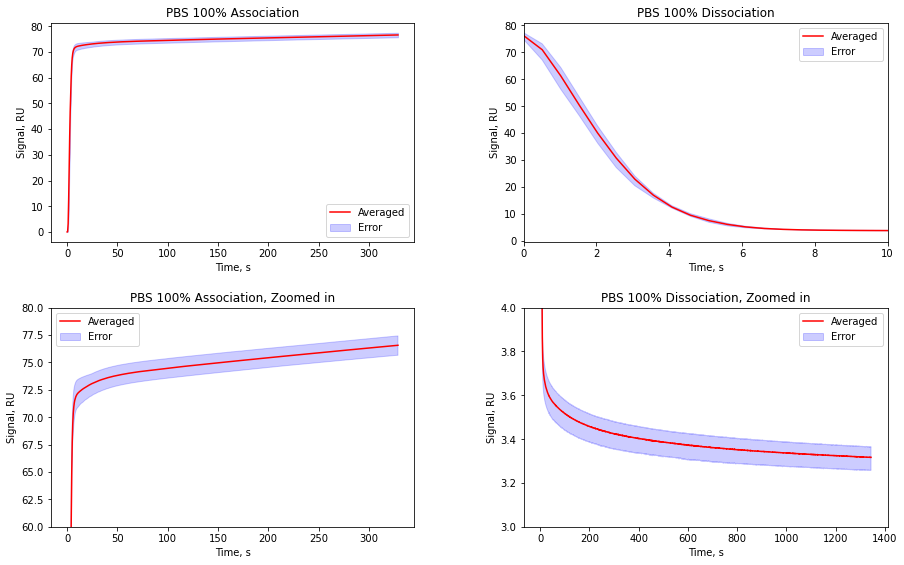

In [2]:
# Build plots of Association and Dissociation of BP proteins
# Red lines represent averaged values, when filled blue area represents experimental errors

f, axs = plt.subplots(2,2, sharey=False)
data100 = np.loadtxt('assoc_PBS_100%.txt')
Ta100 = data100[:, 0]
ya100 = data100[:, 1:]
ta100 = (Ta100-min(Ta100))
ya100ave=np.mean(ya100, axis=1)
ya100min=np.min(ya100, axis=1)
ya100max=np.max(ya100, axis=1)
axs[0,0].plot(ta100, ya100ave, label='Averaged', color='red')
axs[0,0].fill_between(ta100, ya100min, ya100max, label='Error', color='blue', alpha=0.2)
axs[0,0].legend(loc='best')
axs[0,0].set_title('PBS 100% Association')
axs[0,0].set_xlabel("Time, s")
axs[0,0].set_ylabel("Signal, RU")

datd100d = np.loadtxt('diss_PBS_100%.txt')
td100 = datd100d[:, 0]
yd100 = datd100d[:, 1:]
td100 = (td100-min(td100))
#axs[0,1].plot(td100, yd100, '.')
yd100ave=np.mean(yd100, axis=1)
yd100ave=np.mean(yd100, axis=1)
yd100min=np.min(yd100, axis=1)
yd100max=np.max(yd100, axis=1)
axs[0,1].plot(td100, yd100ave, label='Averaged',color='red')
axs[0,1].fill_between(td100, yd100min, yd100max, label='Error', color='blue', alpha=0.2)
axs[0,1].legend(loc='best')
axs[0,1].set_xlim(0,10)
axs[0,1].set_title("PBS 100% Dissociation")
axs[0,1].set_xlabel("Time, s")
axs[0,1].set_ylabel("Signal, RU")


axs[1,0].plot(ta100, ya100ave, label='Averaged', color='red')
axs[1,0].fill_between(ta100, ya100min, ya100max, label='Error', color='blue', alpha=0.2)
axs[1,0].legend(loc='best')
axs[1,0].set_ylim(60, 80)
axs[1,0].set_title('PBS 100% Association, Zoomed in')
axs[1,0].set_xlabel("Time, s")
axs[1,0].set_ylabel("Signal, RU")

axs[1,1].plot(td100, yd100ave, label='Averaged',color='red')
axs[1,1].fill_between(td100, yd100min, yd100max, label='Error', color='blue', alpha=0.2)
axs[1,1].legend(loc='best')
axs[1,1].set_ylim(3, 4)
axs[1,1].set_title("PBS 100% Dissociation, Zoomed in")
axs[1,1].set_xlabel("Time, s")
axs[1,1].set_ylabel("Signal, RU")


f.set_figheight(10)
f.set_figwidth(15)
f.subplots_adjust(top = 1, bottom=0.3, hspace=0.3, wspace=0.3) 
plt.show()

OPTIONAL CLASSES(FUNCTIONS) WHICH CUTS DESIRED PART OF THE CURVE FROM ITS BEGINING 

In [4]:
# CUTS CURVE BY TIME (IN SECONDS)
# Returns numpy array of x or y depending on method

class trans_cut():
    def __init__(self):
        pass
    
    def t_cut(self,cut_time,t,y):
        i=0
        while t[i]<cut_time:
            i+=1
        index=np.arange(0,i)
        t_new=np.delete(t, index)
        t_new=t_new-np.min(t_new)

        return t_new
    
    def y_cut(self,cut_time,t,y):
        i=0
        while t[i]<cut_time:
            i+=1
        index=np.arange(0,i)
        y_new=np.delete(y, index)
        if y_new[0]<y_new[-1]:
            
            y_new=y_new-np.min(y_new)

        return y_new

In [5]:
# THE SAME NAME CLASS, WHICH CUTS CURVE BY LEVEL OF SIGNAL
# Returns numpy array of x or y depending on method

class trans_cut():
    def __init__(self):
        pass
    
    def y_cut(self, level, t, y):
        
        if y[0]<y[-1]:
            indices=np.where(y<level)
            indices=list(indices[0][:])
            y_new=np.delete(y,indices)
            y_new=y_new-level
            t_new=np.delete(t, indices)
            t_new=t_new-np.min(t_new)

            if y_new[0]!=0:
                y_new=np.concatenate([[0],y_new])
                t_new=np.concatenate([t_new, [t_new[-1]+(t_new[-1]-t_new[-2])]])
                
        else:
            start=y[0]-level
            indices=np.where(y>start)
            indices=list(indices[0][:])
            y_new=np.delete(y,indices)
            t_new=np.delete(t, indices)
            t_new=t_new-np.min(t_new)
            
            if y_new[0]!=start:
                y_new=np.concatenate([[start],y_new])
                t_new=np.concatenate([t_new, [t_new[-1]+(t_new[-1]-t_new[-2])]])

        return y_new
    
    def t_cut(self, level, t, y):
        
        if y[0]<y[-1]:
        
            indices=np.where(y<level)
            indices=list(indices[0][:])
            y_new=np.delete(y,indices)
            y_new=y_new-level
            t_new=np.delete(t, indices)
            t_new=t_new-np.min(t_new)

            if y_new[0]!=0:
                y_new=np.concatenate([[0],y_new])
                t_new=np.concatenate([t_new, [t_new[-1]+(t_new[-1]-t_new[-2])]])

        else:
            start=y[0]-level
            indices=np.where(y>start)
            indices=list(indices[0][:])
            y_new=np.delete(y,indices)
            t_new=np.delete(t, indices)
            t_new=t_new-np.min(t_new)
            
            if y_new[0]!=start:
                y_new=np.concatenate([[start],y_new])
                t_new=np.concatenate([t_new, [t_new[-1]+(t_new[-1]-t_new[-2])]])

        return t_new

FUNCTIONS OF SOLUTION OF ODE SYSTEM AND FURTHER FITTING AND OPTIMIZATION 

In [9]:
xa0=[0,0,0]  #Initial conditions to solve Adsorption ODE system

# Function, which defines system of ODE for Adsorption
def assoc_eq(x,ta,b, kc1, kc2, kc3, kd1, kd2, kd3):
    B1=x[0]
    B2=x[1]
    B3=x[2]
    dB1dt=kc1*(b-B1-B2-B3)-kd1*B1             
    dB2dt=kc2*(b-B1-B2-B3)-kd2*B2
    dB3dt=kc3*(b-B1-B2-B3)-kd3*B3
    return np.array([dB1dt,dB2dt,dB3dt])

# Function which solves ODE system for Adsorption
# Returnes values of concentration(SPR signal) of every of three proteins group
def assoc_sol(ta,b,kc1, kc2, kc3, kd1, kd2, kd3):
    x=odeint(assoc_eq,xa0,ta, args=(b,kc1, kc2, kc3, kd1, kd2, kd3))
    aB1=x[:,0]
    aB2=x[:,1]
    aB3=x[:,2]
    return np.array([aB1,aB2,aB3])



# Function, which defines system of ODE for Desorption
def diss_eq(x,td, kc1, kc2, kc3, kd1, kd2, kd3):
    B1=x[0]
    B2=x[1]
    B3=x[2]
    dB1dt=-kd1*B1+kc1*0
    dB2dt=-kd2*B2+kc2*0
    dB3dt=-kd3*B3+kc3*0
    return np.array([dB1dt,dB2dt,dB3dt])

# Function which solves ODE system for Desorption
# Returnes values of concentration(SPR signal) of every of three proteins group

def diss_sol(td, d0, kc1, kc2, kc3, kd1, kd2, kd3):
    x=odeint(diss_eq, d0, td, args=(kc1, kc2, kc3, kd1, kd2, kd3))
    B1=x[:,0]
    B2=x[:,1]
    B3=x[:,2]
    return np.array([B1,B2,B3])

# Function to be minimized(optimized)
# Returns sum of values of 
def opti(pars):
    kc1, kc2, kc3, kd1,kd2,kd3 = pars      # Parameters to be optimized
    b=170                                  # Experimental coefficient; represents equilibrium (max reached) level of the signal
    
    # ASSOCIATION
    approx_ya=assoc_sol(ta, b, *pars)      # Approximating function for Association
    diss_ini=approx_ya[:,-1]               # Last value of Association approximating function, which is used as initial condition to solve ODE system for dissociation
    approx_ya=np.sum(approx_ya,axis=0)     # Summarized simulated signal
    resa = (ya-approx_ya)**2               # Loss(deviation) function for Adsorption
    resa_mean = np.mean(resa)              # Mean value of loss(deviation)   
    
    # DISSOCIATION
    approx_yd=diss_sol(td, diss_ini, *pars)# Approximating function for Dissociation
    approx_yd=np.sum(approx_yd, axis=0)    # Summarized simulated signal
    resd=(yd-approx_yd)**2                 # Loss function fo Desorption
    resd_mean=np.mean(resd)                # Mean value of loss(deviation)
    
    return resa_mean+resd_mean

APPLYING OF FUNCTIONS AND VISUALIZATION

Optimization terminated successfully.
         Current function value: 4.059039
         Iterations: 837
         Function evaluations: 1317
[0.17057671032520483, 1e-05, 0.00010832699801804037, 0.22184746832459962, 0.006055230636016597, 1.7928444489781284e-05]
Association with found coefficients


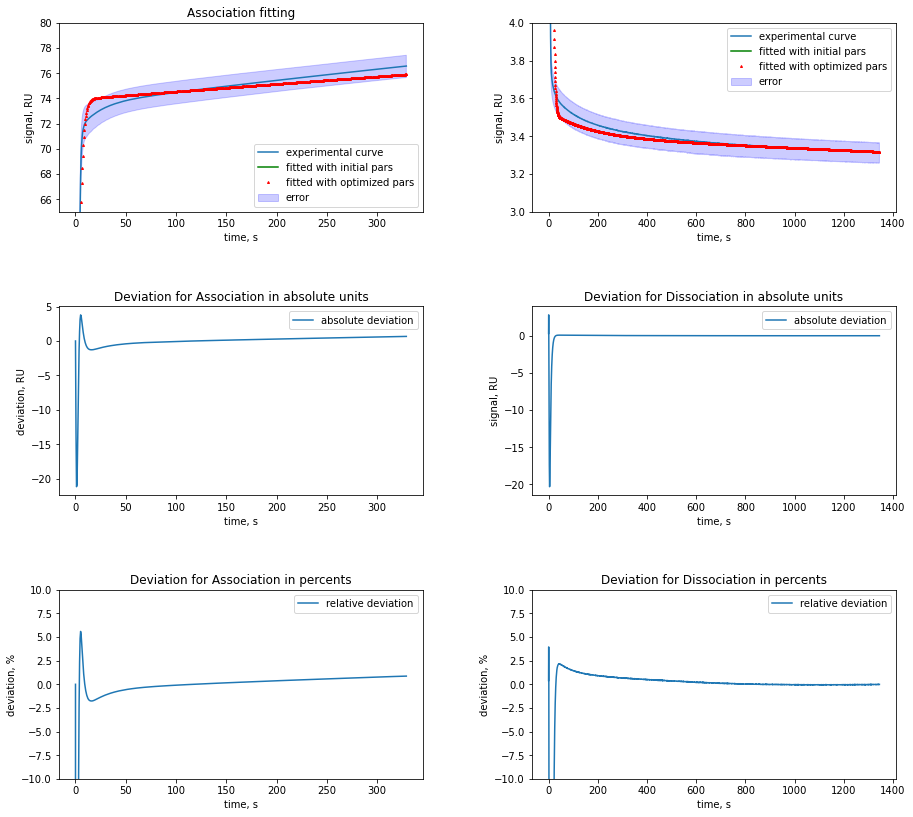

In [43]:
# Applying class for cutting 
cut=0                                 # but cut nothing first
cutit=trans_cut()
ta=cutit.t_cut(cut,ta100,ya100ave)    # time points when Association (experimental), also argument of the Association function 
ya=cutit.y_cut(cut,ta100,ya100ave)    # measured signal when Association 
td=cutit.t_cut(cut,td100,yd100ave)    # time points when Dissociation (experimental), also argument of the Dissociation function
yd=cutit.y_cut(cut,td100,yd100ave)    # measured signal when Dissociation


ini_pars=[0.01,0.00001, 0.0001,0.5,0.001, 0.0001]                                                                   # Initial guessed values of parameters 
bnds=((0.01, 100), (0.00001, 1), (0.000001, 1), (0.01,1), (0.0001,1), (0.000001,1))                                  # Bounderies of parameters pick
multi=minimize(opti, ini_pars, method="Nelder-Mead", bounds=bnds, tol=1e-6, options={'maxiter': 2000, 'disp': True}) # Optimization itself
new_pars = [multi.x[0], multi.x[1], multi.x[2], multi.x[3], multi.x[4], multi.x[5]]                                  # Optimized parameters 
print(new_pars)

                # VISUALIZATION OF OPTIMIZATION RESULTS

print("Association with found coefficients")

f, ax = plt.subplots(3,2)

b=170
ax[0,0].plot(ta, ya, label="experimental curve")
ax[0,0].plot(ta, np.sum(assoc_sol(ta,b,*ini_pars), axis=0), 'g', label="fitted with initial pars")
ax[0,0].plot(ta, np.sum(assoc_sol(ta,b,*new_pars), axis=0),'r^', markersize=2, label="fitted with optimized pars")
ya_min=cutit.y_cut(cut,ta100,ya100min)
ya_max=cutit.y_cut(cut,ta100,ya100max)
while len(ya_max)>len(ya_min):
    ya_max=np.delete(ya_max,[-1])
ta_fill=cutit.t_cut(cut,ta100,ya100min)
ax[0,0].fill_between(ta_fill, ya_min, ya_max, label='error', color='blue', alpha=0.2)
ax[0,0].legend(loc='best')
ax[0,0].set_xlabel('time, s')
ax[0,0].set_ylabel('signal, RU')
ax[0,0].set_ylim(65,80)
ax[0,0].set_title('Association fitting')

d0_new=assoc_sol(ta,b,*new_pars)[:,-1]
d0_ini=assoc_sol(ta,b,*ini_pars)[:,-1]
ini_diss=diss_sol(td,d0_new, *new_pars)


ax[0,1].plot(td, yd, label="experimental curve")
ax[0,1].plot(td, np.sum(diss_sol(td,d0_ini,*ini_pars), axis=0), 'g', label="fitted with initial pars")
ax[0,1].plot(td, np.sum(diss_sol(td,d0_new,*new_pars), axis=0),'r^', markersize=2, label="fitted with optimized pars")
yd_min=cutit.y_cut(cut,td100,yd100min)
yd_max=cutit.y_cut(cut,td100,yd100max)
while len(yd_max)>len(yd_min):
    yd_max=np.delete(yd_max,[-1])
td_fill=cutit.t_cut(cut,td100,yd100min)
ax[0,1].fill_between(td_fill, yd_min, yd_max, label='error', color='blue', alpha=0.2)
ax[0,1].legend(loc='best')
ax[0,1].set_xlabel('time, s')
ax[0,1].set_ylabel('signal, RU')
ax[0,1].set_ylim(3,4)

ax[1,0].plot(ta, ya-np.sum(assoc_sol(ta,b,*new_pars), axis=0), label='absolute deviation' )
ax[1,0].legend(loc='best')
ax[1,0].set_xlabel('time, s')
ax[1,0].set_ylabel('deviation, RU')
ax[1,0].set_title('Deviation for Association in absolute units')

ax[1,1].plot(td, yd-np.sum(diss_sol(td,d0_new,*new_pars), axis=0),label='absolute deviation' )
ax[1,1].legend(loc='best')
ax[1,1].set_xlabel('time, s')
ax[1,1].set_ylabel('signal, RU')
ax[1,1].set_title('Deviation for Dissociation in absolute units')

ax[2,0].plot(ta, (ya-np.sum(assoc_sol(ta,b,*new_pars), axis=0))/(ya+0.00001)*100, label='relative deviation' )
ax[2,0].set_ylim(-10,10)
ax[2,0].legend(loc='best')
ax[2,0].set_xlabel('time, s')
ax[2,0].set_ylabel('deviation, %')
ax[2,0].set_title('Deviation for Association in percents')

ax[2,1].plot(td, (yd-np.sum(diss_sol(td,d0_new,*new_pars), axis=0))/(yd+0.00001)*100 ,label='relative deviation' )
ax[2,1].set_ylim(-10,10)
ax[2,1].legend(loc='best')
ax[2,1].set_xlabel('time, s')
ax[2,1].set_ylabel('deviation, %')
ax[2,1].set_title('Deviation for Dissociation in percents')

f.set_figheight(15)
f.set_figwidth(15)
f.subplots_adjust(top = 1, bottom=0.3, hspace=0.5, wspace=0.3)

plt.show()
